# 简单的LSTM模型进行发电功率预测

导入包

In [1]:
import numpy as np
import os
import tensorflow as tf
import random
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Bidirectional
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# import seaborn as sns
from sklearn import metrics
from numpy import array
from numpy import hstack
from math import sqrt

from sklearn.metrics import mean_squared_error
# tf.random.set_seed(1234)
# random.seed(1234)
# np.random.seed(1234)

In [5]:

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[(i+(n_steps_in - n_steps_out)):end_ix, -1]
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[i:end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)



In [6]:
def seed_tensorflow(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_tensorflow(1)

添加时间变量函数，将时间添加到输入参数当中

In [7]:
def add_time_variables(df: pd.DataFrame) -> pd.DataFrame:
    """
    添加时间变量
    :param df:
    :return:
    """
    df['minute_of_day'] = df.index.hour * 60 + df.index.minute
    df['hour_of_day'] = df.index.hour
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
#     df['doy'] = df.index.dayofyear
    return df

读取clean后的数据，并将空值转换为0

In [14]:
# df=pd.read_csv(r"./wuyuhan/add_time_data_plus/lanneng/add_time_gfs_min.csv",parse_dates=["time"],index_col=[0])
df=pd.read_csv(r"/home/lenovo/wuyuhan/add_time_data_new/add_time_data_day_sensity/lanneng/mid2_cref_50%.csv")
# df = df.iloc[:,-3:]
df.drop('Unnamed: 0',axis = 1,inplace = True)

df['time']= pd.to_datetime(df['time']) 
df['Year'] = df['time'].dt.year 
df['Month'] = df['time'].dt.month
df['Day'] = df['time'].dt.day

df.set_index(keys = 'time',inplace = True)
# where_are_nan = np.isnan(df)
# where_are_inf = np.isinf(df)
# df[where_are_nan] = 0
# df[where_are_inf] = 0

# df = add_time_variables(df)
df = df.fillna(value = 0)
df.shape

(4332, 25)

In [15]:
# df.to_csv(r'E:\wyh202307\add_time_era5_15min_overlap.csv')

In [16]:
df.head()

,minutes,Relative_humidity_isobaric,Temperature_height_above_ground,Downward_Short-Wave_Radiation_Flux_surface_3_Hour_Average,Sensible_heat_net_flux_surface_3_Hour_Average,Potential_Evaporation_Rate_surface,Composite_reflectivity_entire_atmosphere,Sunshine_Duration_surface,Low_cloud_cover_low_cloud,v10-1,...,mcc-1,lspf-1,pev-1,pv-1,r-1,lanneng-1,lanneng,Year,Month,Day
time,,,,,,,,,,,,,,,,,,,,,
2021-01-05 06:00:00,6120,86.433333,282.139017,0.000000,-11.274951,15.481628,2.839994,0.000000,0.0,-0.272444,...,0.0,0.0,8.520000e-07,1.390000e-07,45.138010,0.0000,0.0000,2021,1,5
2021-01-05 07:00:00,6180,87.666667,282.055683,0.000000,-10.957740,20.369789,16.734994,0.000000,0.0,-0.381931,...,0.0,0.0,7.830000e-07,1.500000e-07,49.018260,0.5507,0.0000,2021,1,5
2021-01-05 08:00:00,6240,88.900000,281.972350,0.000000,-10.640528,25.257950,30.629994,0.000000,0.0,-0.526926,...,0.0,0.0,-6.950000e-06,1.320000e-07,51.873783,6.2249,1.3288,2021,1,5
2021-01-05 09:00:00,6300,85.533333,282.263387,73.333333,12.187819,73.669287,18.039994,3599.333333,0.0,-1.337719,...,0.0,0.0,-6.640000e-05,1.260000e-07,53.121407,46.8818,3.1089,2021,1,5
2021-01-05 10:00:00,6360,82.166667,282.554423,146.666667,35.016166,122.080623,5.449994,7198.666667,0.0,-2.376953,...,0.0,0.0,-1.344850e-04,7.510000e-09,50.605130,65.3503,5.5107,2021,1,5


In [17]:
from sklearn.model_selection import train_test_split
df_for_training = df.loc[df['Day']<=24]
df_for_testing  = df.loc[df['Day']>24]

df_for_training = df_for_training.drop(labels = ['Year','Month','Day'], axis = 1)
df_for_testing = df_for_testing.drop(labels = ['Year','Month','Day'] ,axis = 1)

使用后3000条数据进行train和test，其中后3000条的前2400条进行train，后600条进行测test

In [18]:
df_for_testing

,minutes,Relative_humidity_isobaric,Temperature_height_above_ground,Downward_Short-Wave_Radiation_Flux_surface_3_Hour_Average,Sensible_heat_net_flux_surface_3_Hour_Average,Potential_Evaporation_Rate_surface,Composite_reflectivity_entire_atmosphere,Sunshine_Duration_surface,Low_cloud_cover_low_cloud,v10-1,...,tclw-1,ishf-1,str-1,mcc-1,lspf-1,pev-1,pv-1,r-1,lanneng-1,lanneng
time,,,,,,,,,,,,,,,,,,,,,
2021-01-25 06:00:00,34920,85.433333,282.841280,1.333333,-4.692749,16.638231,-30.000006,1242.0,0.000000,-2.027780,...,0.619607,-3.169273,11901.7500,0.814490,3600.00000,-0.000004,1.380000e-06,99.785416,0.0000,0.0000
2021-01-25 07:00:00,34980,83.966667,283.048040,2.666667,-5.040661,20.538728,-30.000006,2484.0,0.000000,-1.950252,...,0.673582,-2.523994,9417.5310,0.725955,3600.00000,-0.000003,1.220000e-06,99.671860,0.0000,0.0000
2021-01-25 08:00:00,35040,82.500000,283.254800,4.000000,-5.388574,24.439224,-30.000006,3726.0,0.000000,-1.873315,...,0.784494,-3.932709,10377.0940,0.794439,3600.00000,-0.000003,9.990000e-07,99.649440,1.6948,6.8679
2021-01-25 09:00:00,35100,83.233333,283.999000,52.666667,5.276424,36.708973,-30.000006,6069.0,0.000000,-2.090513,...,0.807873,-4.150825,5046.1250,0.878473,3600.00000,-0.000009,6.910000e-07,99.411125,3.5743,26.2851
2021-01-25 10:00:00,35160,83.966667,284.743200,101.333333,15.941422,48.978721,-30.000006,8412.0,0.000000,-2.314220,...,0.938309,-7.940720,802.6875,0.961973,3600.00000,-0.000011,4.900000e-07,99.704100,4.3169,50.6445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 13:00:00,524940,44.666667,282.382013,483.086667,52.877959,127.679718,-30.000006,18000.0,0.000000,-0.017962,...,0.246591,-31.797920,-125903.7200,0.960508,306.03820,-0.000063,-3.560000e-09,69.448490,6.1076,70.4134
2021-12-31 14:00:00,525000,47.300000,282.505300,512.980000,30.329239,31.819242,-30.000006,21600.0,0.000000,-0.191365,...,0.203071,-20.900856,-159883.3000,0.947019,441.39600,-0.000077,-3.080000e-08,70.761990,5.4254,60.3868
2021-12-31 15:00:00,525060,51.600000,281.751800,423.913333,46.533569,43.997975,-30.000006,18000.0,1.466667,-0.222731,...,0.213650,-11.730606,-99216.9100,0.913509,819.17810,-0.000042,-1.830000e-08,71.825980,3.2510,39.8576


In [21]:
print(df_for_testing['lanneng'].head(10))

time
2021-01-25 06:00:00     0.0000
2021-01-25 07:00:00     0.0000
2021-01-25 08:00:00     6.8679
2021-01-25 09:00:00    26.2851
2021-01-25 10:00:00    50.6445
2021-01-25 11:00:00    47.2727
2021-01-25 12:00:00    24.0822
2021-01-25 13:00:00    34.7022
2021-01-25 14:00:00    23.8975
2021-01-25 15:00:00    15.1216
Name: lanneng, dtype: float64


In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)

In [23]:
df_for_testing_scaled=scaler.transform(df_for_testing)

In [24]:
df_for_training_scaled.shape

(3408, 22)

In [25]:
df_for_testing_scaled.shape

(924, 22)

In [26]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,53])
    return np.array(dataX),np.array(dataY)        

确定时间步长timestep，即用几行数据去预测下一个数据（dense=1所以是预测一个）

In [28]:
# ------关键！！选择输入输出，即时间步长和预测步长！！！------

# choose a number of time steps
n_steps_in, n_steps_out = 36, 36
# covert into input/output
trainX,trainY = split_sequences(df_for_training_scaled, n_steps_in, n_steps_out)
testX,testY = split_sequences(df_for_testing_scaled, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = trainX.shape[2]

In [29]:
print(trainX.shape)

(3338, 36, 21)


In [30]:
print(trainX)

[[[0.00000000e+00 8.34775443e-01 3.30294287e-01 ... 2.21687587e-01
   3.37925571e-01 0.00000000e+00]
  [1.17882824e-04 8.50020602e-01 3.28280266e-01 ... 2.22454672e-01
   3.84945949e-01 5.66608672e-03]
  [2.35765649e-04 8.65265760e-01 3.26266247e-01 ... 2.21199442e-01
   4.19548815e-01 6.40472548e-02]
  ...
  [6.71932099e-03 1.37618459e-01 7.31555528e-02 ... 2.25174338e-01
   7.62230724e-01 2.59806590e-01]
  [6.83720382e-03 1.55335806e-01 5.58241110e-02 ... 2.30195258e-01
   7.71250905e-01 1.22098150e-02]
  [6.95508664e-03 1.73053152e-01 3.84926667e-02 ... 2.39679219e-01
   7.75276826e-01 0.00000000e+00]]

 [[1.17882824e-04 8.50020602e-01 3.28280266e-01 ... 2.22454672e-01
   3.84945949e-01 5.66608672e-03]
  [2.35765649e-04 8.65265760e-01 3.26266247e-01 ... 2.21199442e-01
   4.19548815e-01 6.40472548e-02]
  [3.53648473e-04 8.23650597e-01 3.33300090e-01 ... 2.20781032e-01
   4.34667365e-01 4.82361257e-01]
  ...
  [6.83720382e-03 1.55335806e-01 5.58241110e-02 ... 2.30195258e-01
   7.71250

In [32]:
print(trainY.shape)

(3338, 36)


In [33]:
print(trainY[0:10,:])

[[0.         0.         0.01366038 0.03196024 0.05665131 0.08630981
  0.05274277 0.03437095 0.04788535 0.04266197 0.00124185 0.
  0.         0.         0.06629418 0.07714189 0.0948568  0.09514978
  0.18737689 0.14266916 0.10314884 0.09843638 0.04237001 0.
  0.         0.         0.05332771 0.17408146 0.09861936 0.10672842
  0.21864321 0.18584308 0.1746294  0.16403664 0.06139976 0.        ]
 [0.         0.01366038 0.03196024 0.05665131 0.08630981 0.05274277
  0.03437095 0.04788535 0.04266197 0.00124185 0.         0.
  0.         0.06629418 0.07714189 0.0948568  0.09514978 0.18737689
  0.14266916 0.10314884 0.09843638 0.04237001 0.         0.
  0.         0.05332771 0.17408146 0.09861936 0.10672842 0.21864321
  0.18584308 0.1746294  0.16403664 0.06139976 0.         0.        ]
 [0.01366038 0.03196024 0.05665131 0.08630981 0.05274277 0.03437095
  0.04788535 0.04266197 0.00124185 0.         0.         0.
  0.06629418 0.07714189 0.0948568  0.09514978 0.18737689 0.14266916
  0.10314884 0.098

In [34]:
print(testY.shape)
testY

(854, 36)


array([[0.        , 0.        , 0.07060366, ..., 0.2449781 , 0.2449781 ,
        0.0428686 ],
       [0.        , 0.07060366, 0.27021712, ..., 0.2449781 , 0.0428686 ,
        0.        ],
       [0.07060366, 0.27021712, 0.52063758, ..., 0.0428686 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.0059903 , ..., 0.05577441, 0.03342106,
        0.01881078],
       [0.        , 0.0059903 , 0.07169953, ..., 0.03342106, 0.01881078,
        0.        ],
       [0.0059903 , 0.07169953, 0.44152291, ..., 0.01881078, 0.        ,
        0.        ]])

In [35]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

构造模型，input_size的第一个参数是timestep，与前面对应一致

In [37]:
# 初始模型
grid_model = Sequential()
# grid_model.add(tf.keras.layers.Dense(32, input_shape=(n_steps_in, n_features)))
# grid_model.add(tf.keras.layers.Conv1D(48, 1, activation='relu'))
grid_model.add(LSTM(144,return_sequences=True,input_shape=(n_steps_in, n_features)))
grid_model.add(Dropout(0.1))
grid_model.add(LSTM(144))
grid_model.add(Dropout(0.1))
# grid_model.add(Dense(32, activation='relu'))

grid_model.add(tf.keras.layers.Dense(n_steps_out, activation='sigmoid'))


    
optimizer=tf.keras.optimizers.Adam()
grid_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
                  metrics = ['accuracy'])


checkpoint_save_path = "./wuyuhan/checkpoint/LSTM_stock.ckpt" #模型保存位置

# if os.path.exists(checkpoint_save_path + '.index'):
#         print('-------------load the model-----------------')
#         grid_model.load_weights(checkpoint_save_path)

lr_reduce = keras.callbacks.ReduceLROnPlateau('val_loss',     #学习停止，模型会将学习率降低2-10倍，该hui
                                                  patience=4,
                                                  factor=0.7,
                                                  min_lr=0.00001)
# best_model = keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,#保存模型
#                                                  monitor='val_loss',
#                                                  verbose=0,
#                                                  save_best_only=True,
#                                                  save_weights_only=True,
#                                                  mode='min',
#                                                  )

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta = 0.00003 , patience=100,mode = 'max' )

    
# grid_model = KerasRegressor(build_fn=build_model,verbose=1)
# parameters = {'batch_size' : [64],
#               'epochs' : [2],
#               'optimizer' : ['adam','Adadelta'],
#              }

# grid_search  = GridSearchCV(estimator = grid_model,
#                             param_grid = parameters,
#                             cv = 2)



history = grid_model.fit(trainX,trainY,validation_data=(testX,testY),epochs = 800,batch_size = 144,
                         callbacks=[early_stop,lr_reduce],verbose = 1,shuffle = False)

Train on 3338 samples, validate on 854 samples
Epoch 1/800
3338/3338 [==============================] - 6s 2ms/sample - loss: 0.0896 - accuracy: 0.0249 - val_loss: 0.0805 - val_accuracy: 0.0304
Epoch 2/800
3338/3338 [==============================] - 3s 870us/sample - loss: 0.0803 - accuracy: 0.0321 - val_loss: 0.0793 - val_accuracy: 0.0445
Epoch 3/800
3338/3338 [==============================] - 3s 928us/sample - loss: 0.0723 - accuracy: 0.0386 - val_loss: 0.0727 - val_accuracy: 0.0515
Epoch 4/800
3338/3338 [==============================] - 3s 900us/sample - loss: 0.0738 - accuracy: 0.0434 - val_loss: 0.0716 - val_accuracy: 0.0726
Epoch 5/800
3338/3338 [==============================] - 3s 885us/sample - loss: 0.0699 - accuracy: 0.0515 - val_loss: 0.0685 - val_accuracy: 0.0691
Epoch 6/800
3338/3338 [==============================] - 3s 879us/sample - loss: 0.0651 - accuracy: 0.0674 - val_loss: 0.0576 - val_accuracy: 0.0913
Epoch 7/800
3338/3338 [==============================] - 3s 8

3338/3338 [==============================] - 3s 838us/sample - loss: 0.0140 - accuracy: 0.2528 - val_loss: 0.0215 - val_accuracy: 0.2869
Epoch 110/800
3338/3338 [==============================] - 3s 849us/sample - loss: 0.0140 - accuracy: 0.2666 - val_loss: 0.0215 - val_accuracy: 0.2904
Epoch 111/800
3338/3338 [==============================] - 3s 840us/sample - loss: 0.0139 - accuracy: 0.2603 - val_loss: 0.0215 - val_accuracy: 0.2916


绘制loss和accuracy曲线

{'batch_size': 144, 'epochs': 800, 'steps': 24, 'samples': 3338, 'verbose': 0, 'do_validation': True, 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}


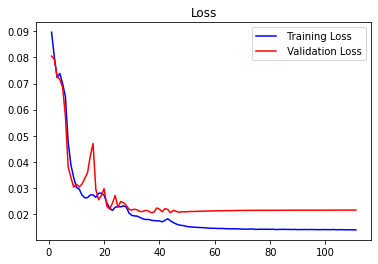

In [38]:
print(history.params)
acc = history.history['accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
 
plt.title('Loss')
# plt.plot(epochs, acc, 'red', label=' Training acc')
plt.plot(epochs, loss, 'blue', label=' Training Loss')
plt.plot(epochs, val_loss, 'red', label=' Validation Loss')


plt.legend()
# plt.savefig('model_test_pic/zhengneng_day/era5_loss_big.png',dpi = 300)
plt.show()

In [33]:
my_model = history

In [34]:
prediction=grid_model.predict(testX)
#print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)
print(prediction)
df = pd.DataFrame(prediction)
a=[]
for i in range(0,len(df),1):##每隔86行取数据
    a.append(i)
file = df.iloc[a].to_numpy()
prediction = file.flatten()
prediction
print(prediction.shape)


Prediction Shape- (854, 36)
[[0.03771949 0.04261732 0.05324906 ... 0.03333938 0.02522564 0.02178556]
 [0.03320017 0.04912609 0.07211185 ... 0.02875757 0.02254337 0.02311689]
 [0.03844944 0.06686643 0.09979132 ... 0.02443761 0.02344182 0.03105628]
 ...
 [0.02068096 0.01828727 0.02251258 ... 0.57575727 0.24056578 0.070375  ]
 [0.01105782 0.02010334 0.05179393 ... 0.27000198 0.0584788  0.01816306]
 [0.01736364 0.04222405 0.10083571 ... 0.07883888 0.02116051 0.01392221]]
(30744,)


In [35]:
df3 = pd.DataFrame(testY)
a=[]
for i in range(0,len(df3),1):##每隔86行取数据
    a.append(i)
file2 = df3.iloc[a].to_numpy()
testY = file2.flatten()
testY
print(testY.shape)

(30744,)


In [36]:
c = np.vstack((prediction,testY))
c
# pd.DataFrame(c).to_csv(r'./LSTM_monthsplit_day/lanneng/era5_min_500ep.csv')

array([[0.03771949, 0.04261732, 0.05324906, ..., 0.07883888, 0.02116051,
        0.01392221],
       [0.        , 0.        , 0.02721552, ..., 0.04969861, 0.        ,
        0.        ]])

In [38]:
# 对预测后的缩放值（-1，1）进行逆变换
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i - 1])
    return inverted
 
 
# 对预测完成的数据进行逆变换
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # 将预测后的数据缩放逆转换
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        # 将预测后的数据差值逆转换
        inv_diff = inverse_difference(last_ob, inv_scale)
        # 保存数据
        inverted.append(inv_diff)
    return inverted


In [39]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i + 1), rmse))

# evaluate_forecasts(testY, prediction, 3, 2)

In [40]:
prediction_copies_array = np.repeat(prediction,n_features+1, axis=-1)

In [41]:
prediction_copies_array.shape
print(prediction_copies_array)

[0.03771949 0.03771949 0.03771949 ... 0.01392221 0.01392221 0.01392221]


10对应的是从0开始，预测值位于第10列，9对应的是从1开始，预测值位于第9列，后续所有的9和10都和预测值所处的列数位置直接关联

In [42]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),n_features+1)))
pred = pred[:,n_features]
pred

array([4.4466977, 5.0240965, 6.277457 , ..., 9.294206 , 2.4945834,
       1.6412704], dtype=float32)

In [43]:
original_copies_array = np.repeat(testY,n_features+1, axis=-1)
original_copies_array.shape
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),n_features+1)))[:,n_features]
original

array([0.    , 0.    , 3.2084, ..., 5.8589, 0.    , 0.    ])

合并预测值和真实值两列数据

In [44]:
c = np.vstack((original,pred))
c
print(c.shape)
pd.DataFrame(c).to_csv(r'./model_test/zhengneng_day/era5_big.csv')

(2, 30744)


计算模型精度！！

In [45]:
def val(y_real,y_pred):
    MSE = metrics.mean_squared_error(y_real,y_pred)
    RMSE = metrics.mean_squared_error(y_real,y_pred)**0.5
    MAE = metrics.mean_absolute_error(y_real,y_pred)
    R2 = metrics.r2_score(y_real,y_pred)
    
    print("MSE:",MSE)
    print("RMSE:",RMSE)
    print("MAE:",MAE)
    print("R2:",R2)
val(original,pred)

MSE: 415.781472081262
RMSE: 20.390720244298926
MAE: 13.835917888824872
R2: 0.6828333772621675


In [46]:
def val(y_real,y_pred):
    MSE = metrics.mean_squared_error(y_real,y_pred)
    RMSE = metrics.mean_squared_error(y_real,y_pred)**0.5
    MAE = metrics.mean_absolute_error(y_real,y_pred)
    R2 = metrics.r2_score(y_real,y_pred)
    
    print("MSE:",MSE)
    print("RMSE:",RMSE)
    print("MAE:",MAE)
    print("R2:",R2)
val(original,pred)

MSE: 415.781472081262
RMSE: 20.390720244298926
MAE: 13.835917888824872
R2: 0.6828333772621675


将array导出为csv，散点图绘制

In [47]:
# pd.DataFrame(c).to_csv(r'./LSTM_monthsplit/zhengneng/gfs_800ep.csv')

作图分析模型精度

In [50]:
prediction=grid_model.predict(testX)
#print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)
print(prediction)
df = pd.DataFrame(prediction)
a=[]
for i in range(0,len(df),n_steps_out):##每隔86行取数据
    a.append(i)
file = df.iloc[a].to_numpy()
prediction = file.flatten()
prediction
print(prediction.shape)





Prediction Shape- (854, 36)
[[0.03771949 0.04261732 0.05324906 ... 0.03333938 0.02522564 0.02178556]
 [0.03320017 0.04912609 0.07211185 ... 0.02875757 0.02254337 0.02311689]
 [0.03844944 0.06686643 0.09979132 ... 0.02443761 0.02344182 0.03105628]
 ...
 [0.02068096 0.01828727 0.02251258 ... 0.57575727 0.24056578 0.070375  ]
 [0.01105782 0.02010334 0.05179393 ... 0.27000198 0.0584788  0.01816306]
 [0.01736364 0.04222405 0.10083571 ... 0.07883888 0.02116051 0.01392221]]
(864,)


In [70]:
df3 = pd.DataFrame(testY)
a=[]
for i in range(0,len(df3),n_steps_out):##每隔86行取数据
    a.append(i)
file2 = df3.iloc[a].to_numpy()
testY = file2.flatten()
testY
print(testY.shape)

(864,)


In [71]:
prediction_copies_array = np.repeat(prediction,n_features+1, axis=-1)

pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),n_features+1)))
pred = pred[:,n_features]
pred

original_copies_array = np.repeat(testY,n_features+1, axis=-1)
original_copies_array.shape
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),n_features+1)))[:,n_features]


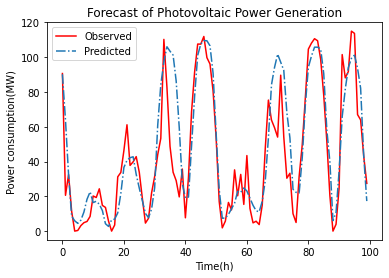

In [72]:
# plt.plot(original[:100,], color = 'red', label = 'Observed')
# plt.plot(pred[:100,], '-.', label = 'Predicted')
# plt.title('Forecast with Updates')
# plt.xlabel('Time(h)')
# plt.ylabel('Power consumption(MW)')
# plt.legend()
# # plt.savefig('CNN-LSTM/lanneng/gfs_500ep.png',dpi = 300)
# plt.show()

fig = plt.figure()
# a1 = fig.add_axes([0,0,1,1])
# a1.set_ylim(-5,100)
# a1.set_xlim(-5,100)
plt.plot(original[200:300,], color = 'red', label = 'Observed')
plt.plot(pred[200:300,], '-.', label = 'Predicted')
plt.ylim(-5,120)
plt.title('Forecast of Photovoltaic Power Generation')
plt.xlabel('Time(h)')
plt.ylabel('Power consumption(MW)')
plt.legend(loc = 'upper left')
plt.savefig('model_test_pic/zhengneng_day/era5_big.png',dpi = 300)
plt.show()

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
#保存模型
grid_model.save('./LSTM_monthsplit/zhengneng/gfs_800ep.h5')

导入模型进行预测，Time单位与数据的time时间分辨率一致，如1Time代表15min

In [52]:
import tensorflow as tf
new_model = tf.keras.models.load_model('./CNN-LSTM/lanneng/gfs_800ep.h5')
prediction=new_model(testX)
prediction_copies_array = np.repeat(prediction,54, axis=-1)
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),54)))
print(pred.shape)
pred = pred[:240,100]
plt.plot(pred, '-.', label = 'Predicted')
plt.title('Forecast with Updates')
plt.xlabel('Time')
plt.ylabel('Power consumption')
plt.legend()
# plt.savefig('figs/Forecast_gfs_all_2.png', dpi = 300)
plt.show()

AttributeError: 'str' object has no attribute 'decode'